In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load_ext line_profiler

In [3]:
import line_profiler
import math
import matplotlib
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import typing as tp

In [4]:
from recombinator.iid_bootstrap import \
    iid_balanced_bootstrap, \
    iid_bootstrap, \
    iid_bootstrap_vectorized, \
    iid_bootstrap_via_choice, \
    iid_bootstrap_via_loop, \
    iid_bootstrap_with_antithetic_resampling

In [5]:
from recombinator.statistics import \
    estimate_bias_from_bootstrap, \
    estimate_confidence_interval_from_bootstrap, \
    estimate_standard_error_from_bootstrap

# I.I.D. Bootstrap: Examples and Performance Analysis

The bootstrap is a statistical resampling method typically used to determine the finite sample properties of an estimator.

Recombinator provides non-parametric bootstrap methods for both i.i.d. and dependent data. This notebook covers the i.i.d case.

The discussion is based on Kevin Sheppard's course notes available at: https://www.kevinsheppard.com/images/6/64/AFE_Week_1_handout.pdf

# An Introductory Example

Consider an i.i.d. sample $\{x_1, ..., x_n\}$ coming from a random variable $x$. 

* An unbiased estimator for the mean is $\bar{x}=\frac{1}{n} \sum_{i=1}^n x_i$.
* One is often interested in aspects of the distribution of an estimator such quantiles or confidence intervals.
* One way to approximate the distribution of this estimator is to resort to asymtotic theory. Under weak assumptions, as the sample size approaches infinity, the estimator is normally distributed with the sample mean equal to the true mean of the $x$ and a the standard deviation equal to the standard error.
* The variance of the estimator is given by
$ \text{SE} \left[ \bar{x} \right]^2 = \text{Var} \left[ \bar{x} \right] = \text{Var} \left[ \frac{1}{n} \sum_{i=1}^n x_i \right] = \frac{1}{n^2} n \text{Var} \left[ x \right] = \frac{1}{n} \text{Var} \left[ x \right]$.
* Hence, the asymptotic distribution of $\bar{x}$ is $N \left( \text{E} \left[ x \right], \frac{1}{n} \text{Var} \left[ x \right] \right)$.
* In practice, the mean $\text{E} \left[ x \right]$ and the variance $\text{Var} \left[ x \right]$ are replaced by their sample analogues $\bar{x}$ and $\frac{1}{n-1} \sum_{i=1}^n \left( x_i - \bar{x} \right)^2$.

There are two central questions:
* How much does the actual distribution for a finite sample size n differ from the limiting distribution as n approaches infinity?
* How do we determine the distribution of statistics other than the mean?

The bootstrap can be used to approximate the final sample distribution of statistic by Monte Carlo simulation. 

# Overview

The idea is to generate R new samples (known as replications) from the original sample with replacement and estimate the statistic (e.g. the sample mean) from each sample. The resulting set of estimates can then be used to compute quantiles and moments of the distribution of the estimator. 

One variation is do draw samples of smaller size $\tilde{n} < n$. This is known as subsampling.

Ideally, we would compute all permuations (or combinations if order does not matter as for the mean) of the original sample. But this grows computaionally infeasible for all but the very smallest samples. This is why we use Monte Carlo to draw a smaller set of new samples.

# I.I.D. Methods

## Non-Balanced Bootstrap

This is the most basic bootstrap approach. For each replication (subsample) r, we draw n random integers as indices into the original data array and return the values at these indices.

## Non-Balanced Bootstrap with Antithetic Sampling

Antithetic sampling is a variance reduction technique commonly used in Monte Carlo simulations. The central idea is to construct negatively correlated samples. This is achieved by first sorting the data. As in the basic bootstrap, one draws a set of indices for each replication. Denote the $i$th sampled index in replication $r$ by $u_{r, i}$. Antithetic samples are then generatet by constructing alternative sequences of indices $\tilde{u}_{r, i} = n - u_{r, i} - 1$

## Balanced Bootstrap

Due to random sampling, some observations appear more often in the R new samples than others. The balanced bootstrap ensures that all original values appear exact R times across the R new samples. Of course in any given sample a particular observation may appear multiple times or not at all.

In what follows, we are comparing different implementations of these algorithms.

# Resampling in Practice

Let's generate an original random sample from a normal distribution of size 100 and take the absolute value.

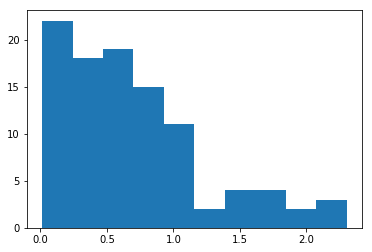

In [6]:
n=100
np.random.seed(1)
x = np.abs(np.random.randn(n))
plt.hist(x);

Estimate the 75th percentile from the original sample

In [7]:
percentile = 75

In [8]:
original_statistic = np.percentile(x, percentile)
original_statistic

0.9322689195424352

Generate R new samples from the original sample via bootstrap

In [9]:
R = 100000

In [10]:
x_resampled \
    = iid_bootstrap(x, replications=R)
x_resampled.shape

(100000, 100)

Estimate the 75th percentile in each of the new samples

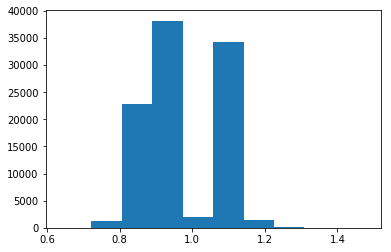

In [11]:
resampled_statistic = np.percentile(x_resampled, percentile, axis=1)
# resampled_statistic.shape
plt.hist(resampled_statistic);

Estimate the standard error of the estimate of the 75th percentile via bootstrap

In [12]:
estimate_standard_error_from_bootstrap(bootstrap_estimates=resampled_statistic,
                                       original_estimate=original_statistic)

0.11259216481248797

Estimate a 95% confidence interval via bootstrap

In [13]:
estimate_confidence_interval_from_bootstrap(bootstrap_estimates=resampled_statistic, 
                                            confidence_level=95)

(0.8405389707805585, 1.1343515900941052)

# Monte-Carlo Study to for the Estimate the Mean of a Normally Distributed Random Variable

Define a linear transformation of the data

In [14]:
a = 0.0
b = 1.0

def f(y):
    return a + b * y

In [15]:
bootstrap_function_name_to_function_map \
    = {'Non-Balanced Bootstrap via Unified Loop': iid_bootstrap,
       'Non-Balanced Bootstrap via Unified Loop with Antithetic Sampling': 
       lambda x, replications: iid_bootstrap(x, 
                                             replications=replications, 
                                             antithetic=True),
       'Non-Balanced Bootstrap via Separated Loop': iid_bootstrap_via_loop,
       'Non-Balanced Bootstrap via Choice': iid_bootstrap_via_choice,
       'Non-Balanced Bootstrap Vectorized': iid_bootstrap_vectorized,
       'Non-Balanced Bootstrap with Antithetic Sampling': iid_bootstrap_with_antithetic_resampling,
       'Balanced Bootstrap': iid_balanced_bootstrap}

np.random.seed(1)

n = 100
x = np.random.randn(n)

# compute sample-average of f(x)
theta = np.mean(f(x))
s2 = 1.0 / (n-1) * np.sum((f(x) - theta)**2)
standard_error = s2/n
replications = 10000

# initialize lists to hold results
bootstrap_methods = []
bootstrap_estimates_of_bias = []
bootstrap_estimates_of_standard_error = []
bootstrap_confidence_intervals = []

for (bootstrap_name, bootstrap_function) in bootstrap_function_name_to_function_map.items():
    x_star = bootstrap_function(x, replications=replications)
    theta_star = np.mean(f(x_star), axis=1)

    bootstrap_estimate_of_bias = estimate_bias_from_bootstrap(theta_star, theta)
    bootstrap_estimate_of_standard_error = estimate_standard_error_from_bootstrap(theta_star, theta)
    bootstrap_confidence_interval = estimate_confidence_interval_from_bootstrap(theta_star)
        
    bootstrap_methods.append(bootstrap_name)
    bootstrap_estimates_of_bias.append(bootstrap_estimate_of_bias)
    bootstrap_estimates_of_standard_error.append(bootstrap_estimate_of_standard_error)
    bootstrap_confidence_intervals.append(bootstrap_confidence_interval)

print(f'estimate of mean from data={theta}')
print(f'asymptotic standard error={np.sqrt(standard_error)}')
print(f'asymptotic confidence interval=({theta - 1.96 * np.sqrt(standard_error)}, {theta + 1.96 * np.sqrt(standard_error)})')

df = pd.DataFrame(data={'Method': bootstrap_methods, 
                        'Bias': bootstrap_estimates_of_bias, 
                        'Standard Error': bootstrap_estimates_of_standard_error,
                        'Confidence Interval': bootstrap_confidence_intervals})
df = df[['Method', 'Bias', 'Standard Error', 'Confidence Interval']]
df

estimate of mean from data=0.060582852075698704
asymptotic standard error=0.08896154673124122
asymptotic confidence interval=(-0.11378177951753408, 0.23494748366893148)


,Method,Bias,Standard Error,Confidence Interval
0,Non-Balanced Bootstrap via Unified Loop,-0.000838,0.088920,"(-0.11504614389291118, 0.2366746073935843)"
1,Non-Balanced Bootstrap via Unified Loop with A...,-0.000083,0.089355,"(-0.11356395881610819, 0.2360893284040337)"
2,Non-Balanced Bootstrap via Separated Loop,0.001266,0.089076,"(-0.11229037997882035, 0.23837384771300493)"
3,Non-Balanced Bootstrap via Choice,0.000251,0.088819,"(-0.11612777210771391, 0.23775586355892206)"
4,Non-Balanced Bootstrap Vectorized,-0.000167,0.089525,"(-0.11186332015622133, 0.23683474609923935)"
5,Non-Balanced Bootstrap with Antithetic Sampling,-0.000023,0.088220,"(-0.11141925698937019, 0.23246309041266683)"
6,Balanced Bootstrap,0.000000,0.087402,"(-0.1098030823908348, 0.22986166853590667)"


We see that in this case of a linear statistic of a normally distributed random variable, the asymptotic approximation of the confidence interval is very close to the actual finite sample result from the bootstrap.

# Monte-Carlo Study for the Estimate of a Non-Linear Function of a Multi-Variate Normal Distribution

Define a nonlinear transformation of the data

In [16]:
def g(x):
    return 2 + x**2 + 3 * x**3 + np.exp(x)

Perform Monte Carlo experiment with different algorithms

In [17]:
bootstrap_function_name_to_function_map \
    = {'Non-Balanced Bootstrap via Unified Loop': iid_bootstrap,
       'Non-Balanced Bootstrap via Separeted Loop': iid_bootstrap_via_loop,
       'Non-Balanced Bootstrap Vectorized': iid_bootstrap_vectorized,
       'Balanced Bootstrap': iid_balanced_bootstrap}

np.random.seed(1)

n = 1000
x = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.25], [0.25, 1]], size=n)

# compute estimate of the sample-average of g(x) 
# and its standard error
theta = np.mean(g(x))
s2 = 1.0 / (n-1) * np.sum((g(x) - theta)**2)
standard_error = s2/n

# number of replications
replications = 10000

# initialize lists to hold results
bootstrap_methods = []
bootstrap_estimates_of_bias = []
bootstrap_estimates_of_standard_error = []
bootstrap_confidence_intervals = []

for (bootstrap_name, bootstrap_function) in bootstrap_function_name_to_function_map.items():
    x_star = bootstrap_function(x, replications=replications)
    theta_star = np.mean(g(x_star), axis=1)

    bootstrap_estimate_of_bias = estimate_bias_from_bootstrap(theta_star, theta)
    bootstrap_estimate_of_standard_error = estimate_standard_error_from_bootstrap(theta_star, theta)
    bootstrap_confidence_interval = estimate_confidence_interval_from_bootstrap(theta_star)
        
    bootstrap_methods.append(bootstrap_name)
    bootstrap_estimates_of_bias.append(bootstrap_estimate_of_bias)
    bootstrap_estimates_of_standard_error.append(bootstrap_estimate_of_standard_error)
    bootstrap_confidence_intervals.append(bootstrap_confidence_interval)

print(f'estimate of mean from data={theta}')
print(f'asymptotic standard error={np.sqrt(standard_error)}')
print(f'asymptotic confidence interval=({theta - 1.96 * np.sqrt(standard_error)}, {theta + 1.96 * np.sqrt(standard_error)})')

df = pd.DataFrame(data={'Method': bootstrap_methods, 
                        'Bias': bootstrap_estimates_of_bias, 
                        'Standard Error': bootstrap_estimates_of_standard_error,
                        'Confidence Interval': bootstrap_confidence_intervals})
df = df[['Method', 'Bias', 'Standard Error', 'Confidence Interval']]
df

estimate of mean from data=4.604871361908453
asymptotic standard error=0.642854070168613
asymptotic confidence interval=(3.3448773843779716, 5.864865339438934)


,Method,Bias,Standard Error,Confidence Interval
0,Non-Balanced Bootstrap via Unified Loop,0.000070,0.683638,"(3.7126059788262262, 5.595231562512575)"
1,Non-Balanced Bootstrap via Separeted Loop,-0.001339,0.684823,"(3.712044590912814, 5.617225141031646)"
2,Non-Balanced Bootstrap Vectorized,-0.001773,0.686792,"(3.7043546315683233, 5.611964808642076)"
3,Balanced Bootstrap,0.000000,0.684742,"(3.712513916736439, 5.599944076087733)"


Note that in the case of this non-linear transformation, the asymptotic approximation is not quite as accurate as in the case of a linear transformation. Feel free to increase the sample size n in the above example to see how the accuracy of the asymptotic approximation improves as n approaches infinity.

# Performance Analysis

## Performance Analysis of One-Dimensional Bootstrap

Length of Data to Sample From

In [18]:
n = 1000

Generate Data to Sample From

In [19]:
x_1d = np.random.randn(n)

Number of Replications

In [20]:
replications = 10000

### Implementation of Non-Balanced Boostrap via Unified Loops

In [21]:
x_star = iid_bootstrap(x_1d, replications=replications, antithetic=False)

In [22]:
x_star.shape

(10000, 1000)

In [23]:
%timeit iid_bootstrap(x_1d, replications=replications, antithetic=False)

67.3 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Implementation of Non-Balanced Boostrap via Separate Loops

In [24]:
x_star = iid_bootstrap_via_loop(x_1d, replications=replications)

In [25]:
x_star.shape

(10000, 1000)

In [26]:
%timeit iid_bootstrap_via_loop(x_1d, replications=replications)

54.3 ms ± 765 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Implementation via NumPy Choice of Non-Balanced Boostrap

In [27]:
%timeit iid_bootstrap_via_choice(x_1d, replications=replications)

65.4 ms ± 828 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Vectorized Implementation of Non-Balanced Boostrap

In [28]:
%timeit iid_bootstrap_vectorized(x_1d, replications=replications)

65.3 ms ± 974 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
# %lprun -f iid_bootstrap_vectorized \
#           iid_bootstrap_vectorized(x, replications=replications)

### Vectorized Implementation of Non-Balanced Boostrap with Antithetic Sampling

In [30]:
%timeit iid_bootstrap_with_antithetic_resampling(x_1d, replications=replications)

70.7 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
# %lprun -f iid_bootstrap_with_antithetic_resampling \
#           iid_bootstrap_with_antithetic_resampling(x, replications=replications)

### Balanced Bootstrap

In [32]:
%timeit iid_balanced_bootstrap(x_1d, replications=replications)

464 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
# %lprun -f iid_balanced_bootstrap \
#           iid_balanced_bootstrap(x, replications=replications)

## Performance Analysis of Multivariate Bootstrap

Length of Data to Sample From

In [34]:
n = 1000

Generate Data to Sample From

In [35]:
x_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.25], [0.25, 1]], size=n)

### Implementation of Non-Balanced Boostrap via Unified Loops

In [36]:
x_star = iid_bootstrap(x_2d, replications=replications, antithetic=False)

In [37]:
%timeit iid_bootstrap(x_2d, replications=replications, antithetic=False)

244 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Implementation of Non-Balanced Boostrap via Separate Loops

In [38]:
x_star = iid_bootstrap_via_loop(x_2d, replications=replications)

In [39]:
%timeit iid_bootstrap_via_loop(x_2d, replications=replications)

141 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Vectorized Implementation of Non-Balanced Boostrap

In [40]:
%timeit iid_bootstrap_vectorized(x_2d, replications=replications)

242 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Resampling on the GPU

This part requires an ArrayFire installation, a compatible GPU, and the installation of Cocos. 

In [41]:
import cocos.numerics as cn
from cocos.device import gpu_sync_wrapper, sync

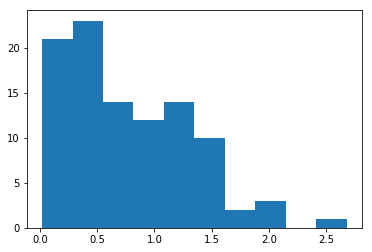

In [42]:
n = 100
cn.random.seed(1)
x_gpu = cn.absolute(cn.random.randn(n))
plt.hist(x_gpu);

In [43]:
x_resampled_via_choice_gpu \
    = iid_bootstrap_via_choice(x_gpu, replications=replications, choice=cn.random.choice)
sync()

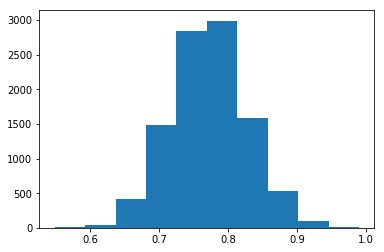

In [44]:
plt.hist(x_resampled_via_choice_gpu.mean(axis=1));

In [45]:
x_resampled_vectorized_gpu \
    = iid_bootstrap_vectorized(x_gpu, replications=R, randint=cn.random.randint)
sync()

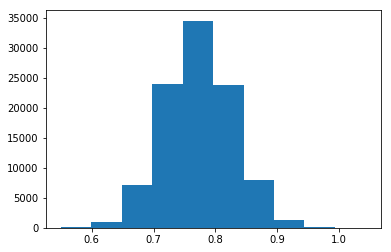

In [46]:
plt.hist(x_resampled_vectorized_gpu.mean(axis=1));

In [47]:
x_resampled_vectorized_antithetic_gpu \
    = iid_bootstrap_with_antithetic_resampling(x_gpu, replications=R, randint=cn.random.randint, num_pack=cn)
sync()

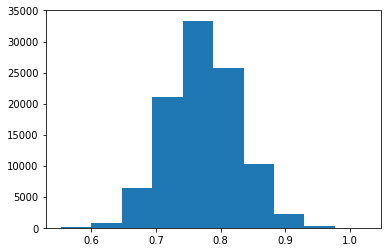

In [48]:
plt.hist(x_resampled_vectorized_antithetic_gpu.mean(axis=1));

## Performance Analysis of One-Dimensional Bootstrap

Transfer data to GPU

In [49]:
x_1d_gpu = cn.array(x_1d)

### Implementation via NumPy Choice of Non-Balanced Boostrap

In [50]:
%timeit gpu_sync_wrapper(iid_bootstrap_via_choice, x_1d_gpu, replications=replications, choice=cn.random.choice)

19.2 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Vectorized Implementation of Non-Balanced Boostrap

In [51]:
%timeit gpu_sync_wrapper(iid_bootstrap_vectorized, x_1d_gpu, replications=replications, randint=cn.random.randint)

19.1 ms ± 79.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Vectorized Implementation of Non-Balanced Boostrap with Antithetic Sampling

In [52]:
%timeit gpu_sync_wrapper(iid_bootstrap_with_antithetic_resampling, x_1d_gpu, replications=replications, num_pack=cn, randint=cn.random.randint)

33 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Balanced Bootstrap

In [53]:
%timeit gpu_sync_wrapper(iid_bootstrap_vectorized, x_1d_gpu, replications=replications, randint=cn.random.randint)

19.1 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Performance Analysis of Multivariate Bootstrap

Transfer data to GPU

In [54]:
x_2d_gpu = cn.array(x_2d)

### Vectorized Implementation of Non-Balanced Boostrap

In [55]:
%timeit gpu_sync_wrapper(iid_bootstrap_vectorized, x_2d_gpu, replications=replications, randint=cn.random.randint)

19.1 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
